In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np
from scipy.stats import wilcoxon
from constants import diffMappingToScore, questions, labelsToElements
from utils import fixationProportionThresholdAnalysis, phaseDetection, dwellRegressionOnRelevantElements, periodCalculation, scanPathPrecision, averageFixationDuration, averageSaccadeAmplitudeForPhases, addQuestionInfo

from functools import reduce
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans

from adjustText import adjust_text

from scipy.stats import pearsonr
from scipy.signal import argrelextrema



In [2]:
#load data
data = pd.read_csv("data/eventsDataWithAois.csv")

In [3]:
data['participant'].unique()

array(['KP1-no', 'KP10-no', 'KP11-no', 'KP12-no', 'KP13-no', 'KP14-no',
       'KP15-no', 'KP16-no', 'KP17-no', 'KP18-no', 'KP19-no', 'KP2-no',
       'KP20-no', 'KP21-no', 'KP22-no', 'KP23-no', 'KP24-no', 'KP3-no',
       'KP4-no', 'KP5-no', 'KP6-no', 'KP7-no', 'KP8-no', 'KP9-no',
       'SP1-no', 'SP10-no', 'SP11-no', 'SP12-no', 'SP13-no', 'SP14-no',
       'SP15-no', 'SP16-no', 'SP17-no', 'SP18-no', 'SP19-no', 'SP2-no',
       'SP20-no', 'SP3-no', 'SP4-no', 'SP5-no', 'SP6-no', 'SP7-no',
       'SP8-no', 'SP9-no'], dtype=object)

In [4]:
#enrich questions with relevant elements
questions = [ {**question,**{'Relevant elements labels': re.findall('"(.+?)"', question["question"])}}  for question in questions ]

for question in questions:
    for idx, label in enumerate(question["Relevant elements labels"]):
        if re.compile("\[(.+?)\]").match(label):
            question["Relevant elements labels"][idx-1] = f'{question["Relevant elements labels"][idx-1]} {label}'
            question["Relevant elements labels"].remove(label)
            
questions = [ {**question,**{'Relevant elements count': len(question["Relevant elements labels"])}}  for question in questions ]

In [5]:
#get activities labels
questions = [ {**question,**{'Relevant elements names':  [ labelsToElements[activity] for  activity in question["Relevant elements labels"] ]   }}  for question in questions ]

In [6]:
#################
#
# Phase detection
#
#################

In [7]:
#drop na
fixationData = data.loc[(~data['FixID'].isna()) & (~data['currentQuestion'].isna())].copy(deep=True)
#add question info
fixationData = addQuestionInfo(fixationData,questions)

"""Q13 (local) and Q25 (global) need to be removed for SP11"""
fixationData = fixationData.drop(fixationData[(fixationData['participant'] == 'SP11-no') & (fixationData['Type3'] == 'Exclusiveness')].index)

In [8]:
fixationData.columns

Index(['participant', 'FixID', 'Fixation X', 'Fixation Y', 'Fixation Start',
       'Fixation End', 'Fixation Duration', 'Fixation Dispersion', 'SacID',
       'Saccade Start', 'Saccade End', 'Saccade Duration', 'Saccade Amplitude',
       'Saccade Peak Velocity', 'Saccade Peak Acceleration',
       'Saccade Peak Deceleration', 'Saccade Direction', 'currentQuestion',
       'tabName_element', 'Timestamp', 'tabName', 'element', 'id', 'question',
       'type', 'options', 'model-group', 'ExpectedAnswer', 'Type1', 'Type2',
       'Type3', 'Relevant elements labels', 'Relevant elements count',
       'Relevant elements names'],
      dtype='object')

In [9]:
#detect phases
phDectFix = phaseDetection(fixationData,questions)

#add Timestamp_formatted column
phDectFix["timestamp_formatted"] = pd.to_datetime(phDectFix['Fixation Start'], unit='ms')

In [10]:
#Initial number of trials (considering control-flow questions only) (considering that """Q13 (local) and Q25 (global) need to be removed for SP11""")
initial_trials = fixationData.loc[fixationData["Type2"]=="Control-flow"].groupby(['participant', 'currentQuestion']).size().reset_index(name='count')
num_initial_trials = len(initial_trials)
print("Initial number of trials:",num_initial_trials)

#Number of trials where participants identified all relevant activities (i.e., the cut is possible to make):
trials_with_phaseCut = phDectFix.loc[(phDectFix["Type2"]=="Control-flow") & (phDectFix["Phase"]!="N/A")].groupby(['participant', 'currentQuestion']).size().reset_index(name='count')
num_trials_with_phaseCut = len(trials_with_phaseCut)
print("trials where participants identified all relevant activities:",num_trials_with_phaseCut)

Initial number of trials: 350
trials where participants identified all relevant activities: 323


In [11]:
phDectFix.columns

Index(['participant', 'FixID', 'Fixation X', 'Fixation Y', 'Fixation Start',
       'Fixation End', 'Fixation Duration', 'Fixation Dispersion', 'SacID',
       'Saccade Start', 'Saccade End', 'Saccade Duration', 'Saccade Amplitude',
       'Saccade Peak Velocity', 'Saccade Peak Acceleration',
       'Saccade Peak Deceleration', 'Saccade Direction', 'currentQuestion',
       'tabName_element', 'Timestamp', 'tabName', 'element', 'id', 'question',
       'type', 'options', 'model-group', 'ExpectedAnswer', 'Type1', 'Type2',
       'Type3', 'Relevant elements labels', 'Relevant elements count',
       'Relevant elements names', 'relevant', 'Phase', 'timestamp_formatted'],
      dtype='object')

In [12]:
#################
#
# ML
#
#################

In [13]:
def calculate_metrics(freq, phDectFix, data):
    
    print("calculate_metrics()")
    
    #######################
    #
    # Average fixation duration
    #
    #######################
    #filter out those with N/A
    print("Average fixation duration")
    avFDPT = averageFixationDuration(phDectFix,['Type1','Type2','Type3','Phase',pd.Grouper(key='timestamp_formatted', freq=freq)])
    avFDPT = avFDPT.loc[avFDPT["Phase"]!="N/A"].copy(deep=True)
    #Keep only control-flow
    avFDPT = avFDPT.loc[avFDPT["Type2"]=="Control-flow"].copy(deep=True)
    # add incremental ID to each group
    avFDPT['phaseTimeIntervalCounter'] = avFDPT.groupby(['currentQuestion','participant','Type1','Type2','Type3','Phase']).cumcount()
    #sorting 
    avFDPT = avFDPT.sort_values(by=['participant','currentQuestion','timestamp'])
    ####################
    #
    # Average Saccade amplitude
    #
    ####################
    print("Average Saccade amplitude")    
    #filter saccadeData
    filtered_data = data.loc[(~data['SacID'].isna()) & (~data['currentQuestion'].isna())].copy(deep=True)
    #filter out those with N/A
    phases = phDectFix.loc[phDectFix["Phase"]!="N/A"].copy(deep=True)
    #Keep only control-flow
    phases = phases.loc[phases["Type2"]=="Control-flow"].copy(deep=True)
    #calculate avSacAmplitude
    avSacAmplitude = averageSaccadeAmplitudeForPhases(phases,filtered_data,['currentQuestion','participant','Type1','Type2','Type3','Phase',pd.Grouper(key='timestamp_formatted', freq=freq)])
    # add incremental ID to each group
    avSacAmplitude['phaseTimeIntervalCounter'] = avSacAmplitude.groupby(['currentQuestion','participant','Type1','Type2','Type3','Phase']).cumcount()
    #sorting (extra)
    avSacAmplitude = avSacAmplitude.sort_values(by=['participant','currentQuestion','timestamp'])
    ####################
    #
    # Scan-path precision
    #
    ####################
    print("Scan-path precision")
    scanPathPrecisionData = scanPathPrecision(phDectFix,['Type1','Type2','Type3','Phase',pd.Grouper(key='timestamp_formatted', freq=freq)])
    #filter out those with N/A
    scanPathPrecisionData = scanPathPrecisionData.loc[scanPathPrecisionData["Phase"]!="N/A"].copy(deep=True)
    #Keep only control-flow
    scanPathPrecisionData = scanPathPrecisionData.loc[scanPathPrecisionData["Type2"]=="Control-flow"].copy(deep=True)
    # add incremental ID to each group
    scanPathPrecisionData['phaseTimeIntervalCounter'] = scanPathPrecisionData.groupby(['currentQuestion','participant','Type1','Type2','Type3','Phase']).cumcount()
    #sorting (extra)
    scanPathPrecisionData = scanPathPrecisionData.sort_values(by=['participant','currentQuestion','timestamp'])
    #######################
    #
    # Fixation threshold proportion analysis
    #
    #######################
    print("Fixation threshold proportion analysis")
    fxThresholdsData = fixationProportionThresholdAnalysis(phDectFix,['Type1','Type2','Type3','Phase',pd.Grouper(key='timestamp_formatted', freq=freq)])
    #filter out those with N/A
    fxThresholdsData = fxThresholdsData.loc[fxThresholdsData["Phase"]!="N/A"].copy(deep=True)
    #Keep only control-flow
    fxThresholdsData = fxThresholdsData.loc[fxThresholdsData["Type2"]=="Control-flow"].copy(deep=True)
    # add incremental ID to each group
    fxThresholdsData['phaseTimeIntervalCounter'] = fxThresholdsData.groupby(['currentQuestion','participant','Type1','Type2','Type3','Phase']).cumcount()
    #sorting (extra)
    fxThresholdsData = fxThresholdsData.sort_values(by=['participant','currentQuestion','timestamp'])
    #######################
    #
    # All measures in one dataframe
    #
    ######################
    #merge all dataframes (computed previously)
    dfs = [avFDPT,
           avSacAmplitude,
           scanPathPrecisionData,fxThresholdsData]
    all_measures = reduce(lambda left,right: pd.merge(left,right,on=['participant', 'currentQuestion', 'Type1', 'Type2', 'Type3', 'Phase','phaseTimeIntervalCounter','timestamp'], how='inner'), dfs)
    all_measures.columns
    
    #drop N/A
    print(len(all_measures))
    all_measures = all_measures.dropna()
    print("after removing nans",len(all_measures))
    
    
    # Reset the index of the filtered DataFrame
    all_measures.reset_index(drop=True, inplace=True)
    
    #sorting 
    all_measures = all_measures.sort_values(by=['participant','currentQuestion','timestamp'])


    return all_measures


def run_cross_validation(all_measures, freq, cross_validation_methods, scoring_metrics):
    
    print("run_cross_validation()")
    
    benchmarks = []

    #########################
    #
    # ML Prediction and validation
    #
    #########################

    #features and labels
    features = ['Average_Fixation_Duration', 
                      'avSaccadeAmplitude',
    'scan_path_precision', 'shortFixationsProp', 
                    
    'longFixationsProp']
    X = all_measures[features]
    y = all_measures['Phase']
    

    #Define the Random Forest classifier with the given parameters
    rf_clf =  RandomForestClassifier(max_depth=5, n_estimators=300, class_weight='balanced')


    # Iterate over the cross-validation methods
    for method in cross_validation_methods:
        
        print("----", method)

        # Get training and testing folds
        cross_validation_folds = constructcvs(all_measures, method, all_measures['participant'].unique(), all_measures['currentQuestion'].unique())

        # Calculate performance metrics using cross_validate and the random forest classifier
        cv_results = cross_validate(rf_clf, X, y, cv=cross_validation_folds, scoring=scoring_metrics)

        precision_value = cv_results['test_precision_weighted'].mean()
        recall_value = cv_results['test_recall_weighted'].mean()
        f1_score_value = cv_results['test_f1_weighted'].mean()
        
        # Fit the model to the data and get the feature importance
        rf_clf.fit(X, y)
        feature_importance = rf_clf.feature_importances_
        
        # Create a dictionary mapping feature names to their importances
        feature_importance_dict = dict(zip(features, feature_importance))
        
        # Benchmarking
        benchmark = {
            "maxWindowSize": freq,
            "Method": method + "-out",
            "Classifier": "Random Forest",
            "Precision": precision_value,
            "Recall": recall_value,
            "F1 Score": f1_score_value,
        }
        
        # Add feature importance to benchmark
        for feature_name, importance in feature_importance_dict.items():
            benchmark[f'feature_importance_{feature_name}'] = importance

        print(benchmark)

        benchmarks.append(benchmark)

    return benchmarks


 #extract a set of train and test folds from a given dataset
def constructcvs(dataset,evalMethod,participantsList,taskList):

    cv = None 

    if evalMethod=='participant':
        print("cross validation method:"+evalMethod)
        cv = list()
        for participantToTtest in participantsList:

            train =  dataset.index[dataset['participant']!=participantToTtest]
            test =  dataset.index[dataset['participant']==participantToTtest]
            if len(test)>0:
                cv.append((train, test))
     
    if evalMethod=='task':
        print("cross validation method:"+evalMethod)
        cv = list()
        for taskToTtest in taskList:

            train =  dataset.index[dataset['currentQuestion']!=taskToTtest]
            test = dataset.index[dataset['currentQuestion']==taskToTtest]
            if len(test)>0:
                cv.append((train, test))


    if evalMethod=='participant-task':
        print("cross validation method:"+evalMethod)
        cv = list()

        for participantToTtest in participantsList:
            for taskToTtest in taskList:

                train =  dataset.index[(dataset['currentQuestion']!=taskToTtest) &   (dataset['participant']!=participantToTtest)   ]
                test = dataset.index[(dataset['currentQuestion']==taskToTtest) &   (dataset['participant']==participantToTtest)     ]
                if len(test)>0:
                    cv.append((train, test))
                    
    return cv    


In [14]:
#Cross validation methods
cross_validation_methods = [
                            'participant',
                            'task',
                            'participant-task'
                           ]

# Define the scoring metrics
scoring_metrics = ['precision_weighted', 'recall_weighted', 'f1_weighted']



In [15]:
#benchmarking

In [16]:
all_benchmarks = []

In [17]:
for freqInt in [5,10,15,20,25,30,35,40,45,50,55,60]:
    
    freq = str(freqInt)+'s'
    
    print("--------",freq)
    
    all_measures = calculate_metrics(freq, phDectFix, data)
    benchmarks = run_cross_validation(all_measures, freq, cross_validation_methods, scoring_metrics,)
    all_benchmarks.extend(benchmarks)        

-------- 5s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
6267
after removing nans 6152
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '5s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.7138849134360276, 'Recall': 0.6937702854714409, 'F1 Score': 0.6952353465259997, 'feature_importance_Average_Fixation_Duration': 0.1161692334267148, 'feature_importance_avSaccadeAmplitude': 0.09526808330763763, 'feature_importance_scan_path_precision': 0.6066459885363897, 'feature_importance_shortFixationsProp': 0.040678577601194144, 'feature_importance_longFixationsProp': 0.14123811712806372}
---- task
cross validation method:task
{'maxWindowSize': '5s', 'Method': 'task-out', 'Classifier': 'Random Forest', 'Precision': 0.7354744225481751, 'Recall': 0.7122551867727185, 'F1 Score': 0.7159343507380354, 'feature_importance_Average_Fixation_Duration

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

{'maxWindowSize': '10s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.7976369433173164, 'Recall': 0.7422194155869088, 'F1 Score': 0.7419507744640303, 'feature_importance_Average_Fixation_Duration': 0.11419459339138467, 'feature_importance_avSaccadeAmplitude': 0.09442627111601928, 'feature_importance_scan_path_precision': 0.5803046214942813, 'feature_importance_shortFixationsProp': 0.04897708562366201, 'feature_importance_longFixationsProp': 0.1620974283746527}
-------- 15s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
2526
after removing nans 2490
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '15s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.7541002011459419, 'Recall': 0.7336586997168493, 'F1 Score': 0.7315768144303957, 'feature_importance_Average_Fixation_Duration': 0.11180310977786408, '

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

{'maxWindowSize': '15s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.8119915064780936, 'Recall': 0.7591008993863905, 'F1 Score': 0.753315114738907, 'feature_importance_Average_Fixation_Duration': 0.11310443745401165, 'feature_importance_avSaccadeAmplitude': 0.08850740549007739, 'feature_importance_scan_path_precision': 0.5882580461778885, 'feature_importance_shortFixationsProp': 0.04897080851488675, 'feature_importance_longFixationsProp': 0.16115930236313586}
-------- 20s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
2069
after removing nans 2034
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '20s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.7722260619651631, 'Recall': 0.7528235202131803, 'F1 Score': 0.7520158971462446, 'feature_importance_Average_Fixation_Duration': 0.12142499973170356, '

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

{'maxWindowSize': '20s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.8260411240269288, 'Recall': 0.7682311548553198, 'F1 Score': 0.7614987502704585, 'feature_importance_Average_Fixation_Duration': 0.11396567160766982, 'feature_importance_avSaccadeAmplitude': 0.0951528078235326, 'feature_importance_scan_path_precision': 0.546744722018639, 'feature_importance_shortFixationsProp': 0.05499515206923791, 'feature_importance_longFixationsProp': 0.1891416464809208}
-------- 25s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
1784
after removing nans 1766
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '25s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.7750868278935875, 'Recall': 0.7562525933265533, 'F1 Score': 0.7546273230755339, 'feature_importance_Average_Fixation_Duration': 0.1204296835709126, 'fea

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

{'maxWindowSize': '25s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.8327291033372413, 'Recall': 0.7740208836571065, 'F1 Score': 0.7667160872941385, 'feature_importance_Average_Fixation_Duration': 0.1117116979759688, 'feature_importance_avSaccadeAmplitude': 0.08815057573156375, 'feature_importance_scan_path_precision': 0.5638946551378259, 'feature_importance_shortFixationsProp': 0.0488096727476437, 'feature_importance_longFixationsProp': 0.18743339840699785}
-------- 30s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
1599
after removing nans 1579
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '30s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.7897444063039771, 'Recall': 0.770430976381381, 'F1 Score': 0.7685376427945855, 'feature_importance_Average_Fixation_Duration': 0.0967014173153029, 'fea

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

{'maxWindowSize': '30s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.8462804283574962, 'Recall': 0.797423895334112, 'F1 Score': 0.7871997107723752, 'feature_importance_Average_Fixation_Duration': 0.09788870595679569, 'feature_importance_avSaccadeAmplitude': 0.08548504824317123, 'feature_importance_scan_path_precision': 0.5820008451633493, 'feature_importance_shortFixationsProp': 0.0488142535788363, 'feature_importance_longFixationsProp': 0.18581114705784743}
-------- 35s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
1441
after removing nans 1427
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '35s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.8207875237947473, 'Recall': 0.7962184769377507, 'F1 Score': 0.7932955329924609, 'feature_importance_Average_Fixation_Duration': 0.10683318823394256, 'f

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

{'maxWindowSize': '35s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.8546916969871416, 'Recall': 0.8168704962048615, 'F1 Score': 0.8043770407710442, 'feature_importance_Average_Fixation_Duration': 0.11015947699449531, 'feature_importance_avSaccadeAmplitude': 0.07808479638493762, 'feature_importance_scan_path_precision': 0.5743453176450887, 'feature_importance_shortFixationsProp': 0.05426417693729513, 'feature_importance_longFixationsProp': 0.1831462320381833}
-------- 40s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
1364
after removing nans 1345
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '40s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.8058827039858422, 'Recall': 0.7893504841343583, 'F1 Score': 0.7872315857026494, 'feature_importance_Average_Fixation_Duration': 0.0923667225179467, 'f

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'maxWindowSize': '40s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.8413524660262829, 'Recall': 0.8031292580828184, 'F1 Score': 0.7908270865701206, 'feature_importance_Average_Fixation_Duration': 0.09686019735825974, 'feature_importance_avSaccadeAmplitude': 0.0843991445646039, 'feature_importance_scan_path_precision': 0.5909931302206071, 'feature_importance_shortFixationsProp': 0.05993927464853883, 'feature_importance_longFixationsProp': 0.16780825320799056}
-------- 45s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
1271
after removing nans 1260
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '45s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.8107609931442247, 'Recall': 0.7885778273938712, 'F1 Score': 0.785567309209237, 'feature_importance_Average_Fixation_Duration': 0.09571169457976215, 'f

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

{'maxWindowSize': '45s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.8373223499926287, 'Recall': 0.8040284534866579, 'F1 Score': 0.7867394330242626, 'feature_importance_Average_Fixation_Duration': 0.09477748398387528, 'feature_importance_avSaccadeAmplitude': 0.06423538893488731, 'feature_importance_scan_path_precision': 0.6406568196525079, 'feature_importance_shortFixationsProp': 0.05152429900015731, 'feature_importance_longFixationsProp': 0.14880600842857217}
-------- 50s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
1218
after removing nans 1209
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '50s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.811705945609344, 'Recall': 0.7969165271546558, 'F1 Score': 0.7951530183970096, 'feature_importance_Average_Fixation_Duration': 0.0917755103358429, 'f

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

{'maxWindowSize': '50s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.832575495110325, 'Recall': 0.8017224433633101, 'F1 Score': 0.7859063880735708, 'feature_importance_Average_Fixation_Duration': 0.09676192963272799, 'feature_importance_avSaccadeAmplitude': 0.08157549043342172, 'feature_importance_scan_path_precision': 0.5661589632759553, 'feature_importance_shortFixationsProp': 0.05170726259083179, 'feature_importance_longFixationsProp': 0.20379635406706337}
-------- 55s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
1163
after removing nans 1156
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '55s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.8252125570892912, 'Recall': 0.8012048947263947, 'F1 Score': 0.7974249061579578, 'feature_importance_Average_Fixation_Duration': 0.1053049367403832, 'f

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

{'maxWindowSize': '55s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.8474598874637573, 'Recall': 0.8207098628925255, 'F1 Score': 0.8029305289367209, 'feature_importance_Average_Fixation_Duration': 0.09805626707379025, 'feature_importance_avSaccadeAmplitude': 0.0755304109437544, 'feature_importance_scan_path_precision': 0.5801068013543047, 'feature_importance_shortFixationsProp': 0.05896443580312174, 'feature_importance_longFixationsProp': 0.187342084825029}
-------- 60s
calculate_metrics()
Average fixation duration
Average Saccade amplitude
Scan-path precision
Fixation threshold proportion analysis
1125
after removing nans 1114
run_cross_validation()
---- participant
cross validation method:participant
{'maxWindowSize': '60s', 'Method': 'participant-out', 'Classifier': 'Random Forest', 'Precision': 0.8212554665939984, 'Recall': 0.7997046503474675, 'F1 Score': 0.7964990335336964, 'feature_importance_Average_Fixation_Duration': 0.09130743927141953, 'fe

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

{'maxWindowSize': '60s', 'Method': 'participant-task-out', 'Classifier': 'Random Forest', 'Precision': 0.8390789824701811, 'Recall': 0.8131615804216422, 'F1 Score': 0.7944704676128825, 'feature_importance_Average_Fixation_Duration': 0.09290477628027079, 'feature_importance_avSaccadeAmplitude': 0.07730318870709951, 'feature_importance_scan_path_precision': 0.6054244714279959, 'feature_importance_shortFixationsProp': 0.060797644892166, 'feature_importance_longFixationsProp': 0.1635699186924678}


In [18]:
all_benchmarks

[{'maxWindowSize': '5s',
  'Method': 'participant-out',
  'Classifier': 'Random Forest',
  'Precision': 0.7138849134360276,
  'Recall': 0.6937702854714409,
  'F1 Score': 0.6952353465259997,
  'feature_importance_Average_Fixation_Duration': 0.1161692334267148,
  'feature_importance_avSaccadeAmplitude': 0.09526808330763763,
  'feature_importance_scan_path_precision': 0.6066459885363897,
  'feature_importance_shortFixationsProp': 0.040678577601194144,
  'feature_importance_longFixationsProp': 0.14123811712806372},
 {'maxWindowSize': '5s',
  'Method': 'task-out',
  'Classifier': 'Random Forest',
  'Precision': 0.7354744225481751,
  'Recall': 0.7122551867727185,
  'F1 Score': 0.7159343507380354,
  'feature_importance_Average_Fixation_Duration': 0.11910626887633821,
  'feature_importance_avSaccadeAmplitude': 0.09487721167576002,
  'feature_importance_scan_path_precision': 0.5925823496776915,
  'feature_importance_shortFixationsProp': 0.046193099540942695,
  'feature_importance_longFixationsP

In [19]:
# Performance plots

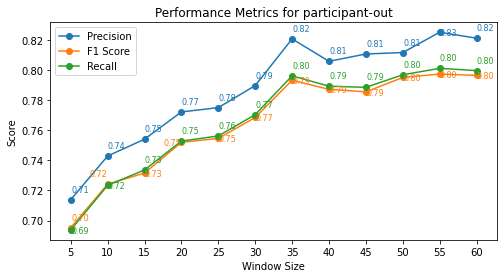

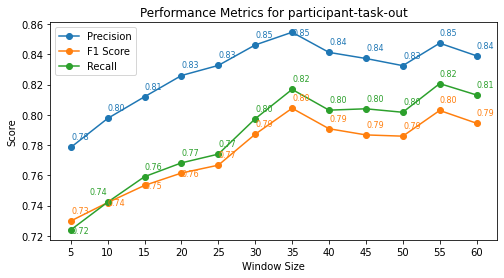

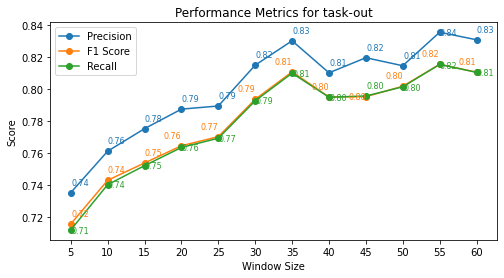

In [20]:
# Convert maxWindowSize to integers for easier sorting
df = pd.DataFrame(all_benchmarks)

df['maxWindowSize'] = df['maxWindowSize'].str.extract('(\d+)').astype(int)

# Group data by Method
grouped = df.groupby('Method')

# Function to annotate data points
def annotate_points(x, y, ax, label, color, fontsize=8):
    texts = []
    for i, txt in enumerate(y):
        texts.append(ax.annotate(f"{label}{txt:.2f}", (x[i], y[i]), textcoords="offset points", 
                                 xytext=(0, 5), ha='center', fontsize=fontsize, color=color))
    return texts


# Iterate over the grouped data and plot the performance metrics
for method, group in grouped:
    group = group.reset_index(drop=True)  # Reset the index of the group DataFrame
    fig, ax = plt.subplots(figsize=(8, 4))  # Increase the figure size
    plt.title(f"Performance Metrics for {method}")

    # Plot lines and store their colors

    
    prec_line, = ax.plot(group['maxWindowSize'], group['Precision'], label='Precision', marker='o')
    prec_color = prec_line.get_color()
    
    f1_line, = ax.plot(group['maxWindowSize'], group['F1 Score'], label='F1 Score', marker='o')
    f1_color = f1_line.get_color()
    
    acc_line, = ax.plot(group['maxWindowSize'], group['Recall'], label='Recall', marker='o')
    acc_color = acc_line.get_color()

    plt.xlabel('Window Size')
    plt.ylabel('Score')
    plt.legend()
    
    # Set x-ticks for every 5 seconds if needed
    max_window = group['maxWindowSize'].max()
    plt.xticks(range(min(group['maxWindowSize']), max_window + 5, 5))  # Adjusting the range and step for x-ticks


    # Annotate data points with corresponding line colors
    texts = []
    texts.extend(annotate_points(group['maxWindowSize'], group['Recall'], ax, '', acc_color))
    texts.extend(annotate_points(group['maxWindowSize'], group['Precision'], ax, '', prec_color))
    texts.extend(annotate_points(group['maxWindowSize'], group['F1 Score'], ax, '', f1_color))

    # Adjust text positions to avoid overlap
    adjust_text(texts)

    plt.show()

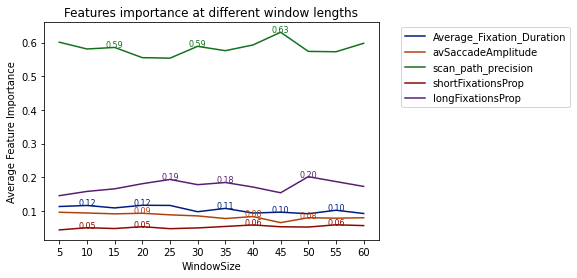

In [21]:
# Feature importance
features = ['Average_Fixation_Duration', 
                      'avSaccadeAmplitude',
    'scan_path_precision', 'shortFixationsProp', 
    'longFixationsProp']

# Define color palette
color_palette = sns.color_palette("dark", len(df.columns[df.columns.str.startswith('feature_importance_')]))


# Getting all the feature importance columns
feature_cols = df.columns[df.columns.str.startswith('feature_importance_')]

# For each feature
for idx, feature in enumerate(feature_cols):
    # Group by maxWindowSize, calculate mean and reset index
    df_grouped = df.groupby('maxWindowSize')[feature].mean().reset_index()
    
    # Plotting
    plt.plot(df_grouped['maxWindowSize'], df_grouped[feature], 
             color=color_palette[idx], label=f'{feature.replace("feature_importance_", "")}')

    # Find local maxima
    y_values = df_grouped[feature].values
    local_maxima = argrelextrema(y_values, np.greater)[0]

    # Adding annotations at local peaks
    for max_index in local_maxima:
        x_value = df_grouped['maxWindowSize'][max_index]
        y_value = y_values[max_index]
        plt.text(x_value, y_value, f'{y_value:.2f}', color=color_palette[idx], fontsize=8, ha='center')

# Set x-ticks for every 5 seconds if needed
max_window = group['maxWindowSize'].max()
plt.xticks(range(min(group['maxWindowSize']), max_window + 5, 5))  # Adjusting the range and step for x-ticks

plt.title('Features importance at different window lengths')
plt.xlabel('WindowSize')
plt.ylabel('Average Feature Importance')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [22]:
for feature in feature_cols:
    print(feature, df[feature].mean())

feature_importance_Average_Fixation_Duration 0.10457588185938012
feature_importance_avSaccadeAmplitude 0.0845044643209388
feature_importance_scan_path_precision 0.584207234883707
feature_importance_shortFixationsProp 0.05219682225290793
feature_importance_longFixationsProp 0.17451559668306615
